In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('max.columns', 100)

import gc
import lightgbm as lgb
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import f1_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score
from sklearn.model_selection import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 读取数据
import pickle

PATH = '../data/'
with open(PATH + 'sliding_windows/x_train_user.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open(PATH + 'sliding_windows/x_val_user.pkl', 'rb') as f:
    x_val = pickle.load(f)
  
y_train = np.load('./work/y_train_user.npy')
y_val = np.load('./work/y_val_user.npy')

In [4]:
x_train.shape, x_val.shape

((1640731, 206), (404693, 206))

In [5]:
y_train.shape, y_val.shape

((1640731,), (404693,))

In [6]:
# 利用PredefinedSplit设置验证集
from sklearn.model_selection import PredefinedSplit
train_val_features = np.concatenate((x_train, x_val),axis=0)
train_val_labels = np.concatenate((y_train, y_val),axis=0)
test_fold = np.zeros(train_val_features.shape[0])   # 将所有index初始化为0,0表示第一轮的验证集
test_fold[:x_train.shape[0]] = -1            # 将训练集对应的index设为-1，表示永远不划分到验证集中
ps = PredefinedSplit(test_fold=test_fold)

del x_train, y_train, x_val, y_val
gc.collect()

13

In [7]:
train_val_features.shape, train_val_labels.shape

((2045424, 206), (2045424,))

In [10]:
# GridSearchCV
# lg = lgb.LGBMClassifier(silent=False, class_weight='balanced')         #
# param_dist = {"max_depth": [2,3,4],
#               "learning_rate" : [0.01,0.03,0.05,0.08],
#               "num_leaves": [2, 4, 6, 8, 10],
#               "n_estimators": [50, 100, 150, 200]
#              }

# grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = ps, scoring='roc_auc', verbose=5)

# grid_search.fit(train_val_features, train_val_labels)
# grid_search.best_estimator_, grid_search.best_score_

# _____________________________________________________________________


#### gridsearch后复现

In [10]:
# 线上 0.57376
# model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
#          colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
#          max_depth=2, min_child_samples=20, min_child_weight=0.001,
#          min_split_gain=0.0, n_estimators=25, n_jobs=-1, num_leaves=2,
#          objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
#          silent=False, subsample=1.0, subsample_for_bin=200000,
#          subsample_freq=0)

# model.fit(train_val_features, train_val_labels)

# 线上 0.54755
# model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
#          colsample_bytree=1.0, importance_type='split', learning_rate=0.05,
#          max_depth=4, min_child_samples=20, min_child_weight=0.001,
#          min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=9,
#          objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
#          silent=False, subsample=1.0, subsample_for_bin=200000,
#          subsample_freq=0)
# model.fit(train_val_features, train_val_labels)

[LightGBM] [Info] Number of positive: 45917, number of negative: 1999507
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.716361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21519
[LightGBM] [Info] Number of data points in the train set: 2045424, number of used features: 184
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.05,
        max_depth=4, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=9,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [11]:
del train_val_features, train_val_labels
gc.collect()

951

In [12]:
# 加载验证集，进行线下验证
with open(PATH + 'sliding_windows/x_val_user.pkl', 'rb') as f:
    x_val = pickle.load(f)
y_val = np.load('./work/y_val_user.npy')  

val_pred = model.predict(x_val)

In [17]:
val_prediction = pd.DataFrame([val_pred, y_val]).T
val_prediction.columns = ['Prediction', 'Truth']
val_prediction['Prediction'] = val_prediction.Prediction 

# 求ROC
roc_auc_score(y_val, val_prediction.Prediction)

0.9796080208359657

#### 线上预测

In [18]:
with open(PATH + 'sliding_windows/x_test_user.pkl', 'rb') as f:
    x_test = pickle.load(f)

In [20]:
sub_pred = model.predict(x_test.loc[:,x_test.columns != 'label'])

sub_prediction = pd.DataFrame(sub_pred)
sub_prediction.columns = ['result']
sub_prediction['customer_id'] = x_test.customer_id.values

In [22]:
# 将结果聚合到submission
submission= pd.read_csv('../data/submission.csv')

In [23]:
submission = submission.merge(sub_prediction, on='customer_id', how='outer').fillna(0)
submission.drop(columns='result_x', inplace=True)
submission.columns = ['customer_id', 'result']
submission['result'] = submission.result.apply(lambda x: 1 if x>=0.5 else 0)

In [24]:
# 预测出30127个购买记录
submission.result.sum()

30127

In [26]:
submission.to_csv('sub_clf_user_gs.csv', index=False)

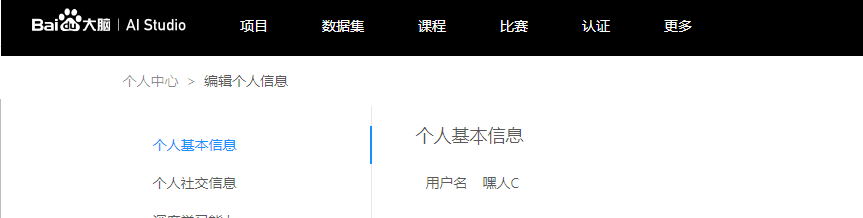
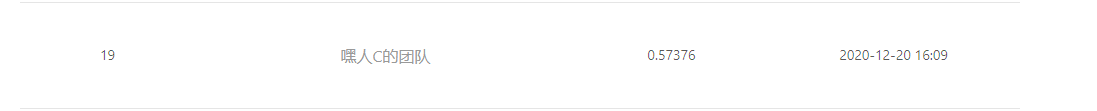

### 小结：
- 本次实验参考了百度官方提供的baseline中的数据处理(时间滑窗，统计用户特征等)，并以LightGBM为主要模型对八月份的用户购买行为进行预测。
- 需要特别注意时间滑窗这部分的学习，防止数据穿越，以未来信息预测未来。
- 下一步，可以再考虑商品的统计特征，商品与用户的组合特征等。
